In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Building and training of PINN
from PINN_2D_Laplace import PhysicsInformedNN

# Geometry and grid
import pygmsh
import meshio

import time

# Solution of the Laplace Equation in a inrregular domain (circle)


## Random sampling in a circle

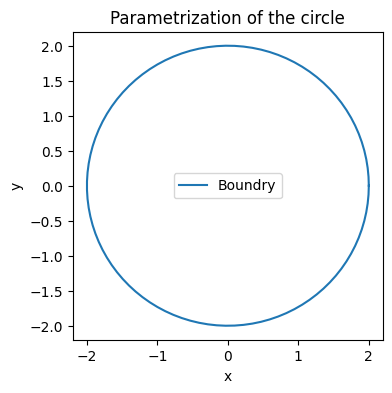

In [4]:
# Parametrization of the circle
r = 2.0 #Radious
theta = np.linspace(0, 2*np.pi, 100) #Angle

# Transformation to polar coordenates
def polar(r, theta):
  return r*np.cos(theta), r*np.sin(theta)

x, y = polar(r, theta)

# Graphic
fig= plt.figure(figsize = (4,4))
plt.plot(x,y, '-', label = 'Boundry')

plt.title('Parametrization of the circle')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

In this instance, we need to determinate a uniform distribution for the circle. By definition, for $s\in S^1$ we need to have
$$ P(r<s) = \frac{s^2}{R^2} $$
since is the division between the area of a circle of radious s over a circle radious R. Then, we can define,
$$r = R\sqrt{U},\quad U\sim\text{Uniform[0,1]}$$

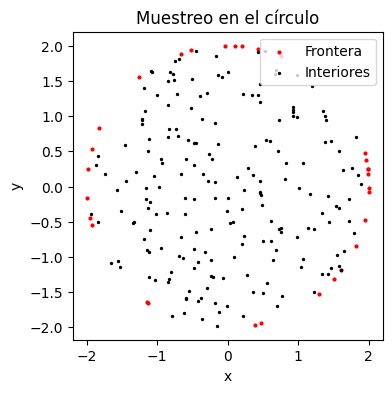

In [6]:
# Random sampling in the interior
R = 2.0
N_int = 200
N_bdy = 30
N_test = 400

# Transformation to polar coordenates
def polar(r, theta):
  return r*np.cos(theta), r*np.sin(theta)

# Sampling in boundry
theta_bdy = np.random.uniform(0, 2*np.pi, N_bdy)

# Uniform sampling (2D)
theta_sample = np.random.uniform(0, 2*np.pi, N_int)
r_sample = R * np.sqrt(np.random.uniform(0, 1, N_int))

# Test data
theta_test = np.random.uniform(0, 2*np.pi, N_test)
r_test = R * np.sqrt(np.random.uniform(0, 1, N_test))

# Transformation
x_bdy, y_bdy = polar(R, theta_bdy)          # Boundry
xu, yu = polar(r_sample, theta_sample)      # Interior
x_test, y_test = polar(r_test, theta_test)  # Test

X_bdy = np.hstack([x_bdy, y_bdy])             # Boundry
Xu = np.hstack([xu, yu])                      # Interior
X_test = np.hstack([x_test, y_test])          # Test

# Graphic
fig, ax = plt.subplots(ncols = 1, figsize = (4,4))
# ax.plot(x,y, '-')
ax.scatter(x_bdy, y_bdy, s=4, color = 'red', label = 'Frontera')
ax.scatter(xu, yu, s=2, color = 'black', label = 'Interiores')

ax.set_title('Muestreo en el círculo')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

# Test graphic
#ax[1].plot(x,y, '-')
#ax[1].scatter(x_test, y_test, s=1, color = 'g', label = 'Test')

#ax[1].set_title('Test Sampling')
#ax[1].set_xlabel('x')
#ax[1].legend()

plt.savefig('CircleSampling.png')
plt.show()

### Vector Normal

In [8]:
def N_circ(X): # vector de coordenadas
    return (1/R)*X/np.sqrt(np.sum(X**2))

X = np.array([x_bdy, y_bdy]).T
NN = N_circ(X)

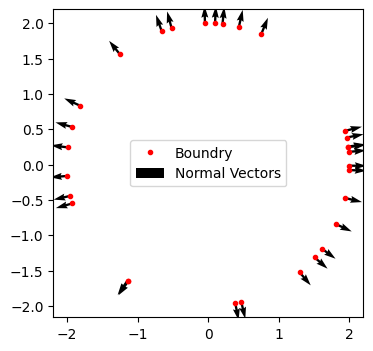

In [9]:
plt.figure(figsize = (4,4))
plt.plot(x_bdy, y_bdy, '.r', label = 'Boundry')

# Vectores normales
plt.quiver(x_bdy, y_bdy, NN[:,0], NN[:,1], label = 'Normal Vectors')

plt.legend()
plt.show()

## División de tipos de condiciones

In [11]:
# División de los pts bdy en dos mitades, en ángulo
u_theta = theta_bdy[theta_bdy < np.pi]
nn_theta = theta_bdy[theta_bdy >= np.pi]

# Determinación de los puntos (x,y)
u_x, u_y = polar(R, u_theta) # Dirichlet

# Neumman
nn_x, nn_y = polar(R, nn_theta)
nn_X = np.array([nn_x, nn_y]).T

nn_dX = N_circ(nn_X)

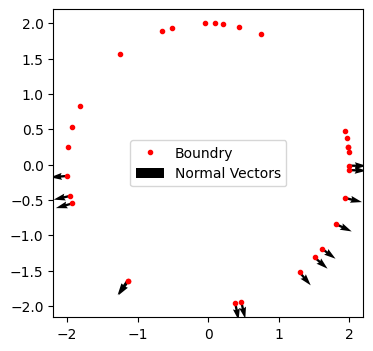

In [12]:
plt.figure(figsize = (4,4))
plt.plot(x_bdy, y_bdy, '.r', label = 'Boundry')

# Vectores normales
plt.quiver(nn_x, nn_y, nn_dX[:,0], nn_dX[:,1], label = 'Normal Vectors')

plt.legend()
plt.show()

# PINNs implementation

# Data processing for PINN

In [52]:
#======================================================================#
#                        RUTINA PARA LA SOLUCIÓN                       #
# ---------------------------------------------------------------------#
# Este script entrena una red neuronal para resolver un problema       #
# elíptico bidimensional mediante el enfoque de PINNs. Se usan puntos  #
# de frontera para entrenar la condición de frontera y puntos de       #
# colocación aleatorios para imponer la PDE                            #
#======================================================================#

if __name__ == "__main__":  
    
    #-------------------------------
    N_bdy = 32   # Puntos de entrenamiento en la frontera
    N_int = 91   # Puntos de colocación en el dominio interior

    NN = 40
    N_train = NN + 1  # Número de nodos en x (malla para entrenamiento)

    Np = NN + 1  # Nodos en x para predicción

    Ne = 20        # Neuronas por capa oculta

    coef = [1, 0 , 1, 0, 0, 0] # Coeficientes de la PDE
    layers = [2, Ne, Ne, Ne, 1]  # Arquitectura: entrada, 3 ocultas, salida
    epochs = 5000

    #-------------------------------
    # Mostrar resumen de parámetros en consola
    print('  ')
    print('---------------------------------------------')
    print('              PROBLEMA ELÍPTICO              ')
    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de frontera          N_bdy =', N_bdy)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('---------------------------------------------')
    print('  MALLA DE PREDICCIÓN:', Np)
    print('---------------------------------------------')
    print('  ')

    # .----------------------------------------------.
    # |           MALLA: DOMINIO 2D                  |
    # .______________________________________________.

    # ===========================================================
    # 1. Parámetros del círculo
    # ===========================================================
    R = 1.0       # radio
    lc = 0.2      # tamaño característico

    # ===========================================================
    # 2. Geometría con API moderna de pygmsh
    # ===========================================================
    with pygmsh.geo.Geometry() as geom:
        # Crear un círculo (curva cerrada)
        circle = geom.add_circle([0.0, 0.0, 0.0], R, mesh_size=lc)

        # Crear la superficie delimitada por ese círculo
        plane_surface = geom.add_plane_surface(circle.curve_loop)

        # Etiquetas físicas
        geom.add_physical(circle.curve_loop.curves, label="Frontera")
        geom.add_physical(plane_surface, label="Interior")

        # Generar malla
        mesh = geom.generate_mesh()

    # ===========================================================
    # 3. Extraer datos
    # ===========================================================
    points = mesh.points[:, :2]
    cells  = mesh.get_cells_type("triangle")

    # ===========================================================
    # 4. Clasificar nodos frontera/interior
    # ===========================================================
    tol = 1e-3
    radii = np.sqrt(points[:,0]**2 + points[:,1]**2)
    boundary_nodes = np.where(np.abs(radii - R) < tol)[0]
    interior_nodes = np.where(radii < R - tol)[0]

    xp = points[:,0]
    yp = points[:,1]
    
    # .----------------------------------------------.
    # |       SOLUCIÓN EXACTA (para referencia)      |
    # .______________________________________________.

    # Generar solución exacta en malla de entrenamiento
    N = len(xp)
    up_star = np.zeros(N)
    for i in range(N):
        up_star[i] = np.exp(xp[i]) * np.cos(yp[i])

    Xp_star = np.vstack([xp, yp]).T # Cambio relevante
    
    # .----------------------------------------------.
    # |     PUNTOS DE ENTRENAMIENTO Y COLOCACIÓN     |
    # .______________________________________________.

    # Sampling in boundry
    theta_bdy = np.random.uniform(0, 2*np.pi, N_bdy)

    # Uniform sampling (2D)
    theta_sample = np.random.uniform(0, 2*np.pi, N_int)
    r_sample = R * np.sqrt(np.random.uniform(0, 1, N_int))

    # Transformation to polar coordenates
    def polar(r, theta):
        return r*np.cos(theta), r*np.sin(theta)
    
    # Transformation
    x_bdy, y_bdy = polar(R, theta_bdy)              # Boundry
    xu, yu = polar(r_sample, theta_sample)          # Interior

    X_u_train = np.vstack([x_bdy, y_bdy]).T         # Boundry
    X_f_train = np.vstack([xu, yu]).T               # Interior

    # Boundry conditions
    u_train = np.zeros((N_bdy, 1))
    for i in range(N_bdy):
        u_train[i, 0] = np.exp(x_bdy[i]) * np.cos(y_bdy[i])

    # Right Hand Side: f(x,y) = 0
    
    rhs = np.zeros((N_int, 1))
    rhs_train = rhs

    # .================================================================.
    # | [S.2]                  APROXIMACIÓN                            |
    # .================================================================.

    # .----------------------------------------------.
    # |     ENTRENAMIENTO DEL MODELO (PINN)          |
    # .______________________________________________.

    #  Construcción de la red neuronal con condiciones físicas
    model = PhysicsInformedNN(X_u_train, u_train,
                              X_f_train, rhs_train,
                              layers, epochs, 1e-3)

    # Entrenamiento de la red neuronal
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time

    # .----------------------------------------------.
    # |         PREDICCIÓN SOBRE NUEVA MALLA         |
    # .______________________________________________.

    up_pred = model.predict(Xp_star).reshape(N)   # un solo vector de predicciones

    # .----------------------------------------------.
    # |     CÁLCULO DE ERRORES L2 Y MÁXIMO           |
    # .______________________________________________.

    error_u   = np.linalg.norm(up_star - up_pred, 2) / np.linalg.norm(up_star, 2)
    error_max = np.linalg.norm(up_star - up_pred, np.inf)

    # .================================================================.
    # | [S.3]              VISUALIZACIÓN DE RESULTADOS                 |
    # .================================================================.

    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de entrenamiento     N_train =', N_train)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('---------------------------------------------')
    print('  MALLA DE PREDICCIÓN:', Np)
    print('---------------------------------------------')
    print('   N_train    N_int    Norma L2       Norma máx')
    print('  %3s   %3s   %e    %e' % (N_train, N_int, error_u, error_max))
    print('---------------------------------------------')
    print('  Tiempo de entrenamiento: %.4f segundos' % (elapsed))
    print('---------------------------------------------')
    print('  ')

  
---------------------------------------------
              PROBLEMA ELÍPTICO              
---------------------------------------------
  ENTRENAMIENTO:                             
  Puntos de frontera          N_bdy = 32
  Puntos de colocalización    N_int = 91
---------------------------------------------
  RED NEURONAL:                             
  Capas = [2, 20, 20, 20, 1]
---------------------------------------------
  MALLA DE PREDICCIÓN: 41
---------------------------------------------
  
Epoch 0, Loss: 1.98847e+00,  U_loss: 1.98126e+00, f_loss: 7.20967e-03
Epoch 100, Loss: 1.94598e-01,  U_loss: 1.58515e-01, f_loss: 3.60828e-02
Epoch 200, Loss: 1.26424e-01,  U_loss: 1.21349e-01, f_loss: 5.07534e-03
Epoch 300, Loss: 1.01892e-01,  U_loss: 8.66616e-02, f_loss: 1.52309e-02
Epoch 400, Loss: 8.12412e-02,  U_loss: 6.51708e-02, f_loss: 1.60704e-02
Epoch 500, Loss: 5.39341e-02,  U_loss: 3.80555e-02, f_loss: 1.58786e-02
Epoch 600, Loss: 2.41141e-02,  U_loss: 1.53248e-02, f_loss: 

Promedio de péridas y de entrenemientos

In [54]:
err = []
times = []

exp = 100

for _ in range(exp):
    #  Construcción de la red neuronal con condiciones físicas
    model = PhysicsInformedNN(X_u_train, u_train,
                              X_f_train, rhs_train,
                              layers, epochs, 1e-3)

    # Entrenamiento de la red neuronal
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time

    # .----------------------------------------------.
    # |         PREDICCIÓN SOBRE NUEVA MALLA         |
    # .______________________________________________.

    up_pred = model.predict(Xp_star).reshape(N)   # un solo vector de predicciones

    # .----------------------------------------------.
    # |     CÁLCULO DE ERROR MÁXIMO           |
    # .______________________________________________.
    error_max = np.linalg.norm(up_star - up_pred, np.inf)

    err.append(error_max)
    times.append(elapsed)

Epoch 0, Loss: 2.68581e+00,  U_loss: 2.38522e+00, f_loss: 3.00593e-01
Epoch 100, Loss: 2.17945e-01,  U_loss: 1.57328e-01, f_loss: 6.06174e-02
Epoch 200, Loss: 1.70134e-01,  U_loss: 1.45021e-01, f_loss: 2.51130e-02
Epoch 300, Loss: 1.42434e-01,  U_loss: 1.35288e-01, f_loss: 7.14560e-03
Epoch 400, Loss: 1.13619e-01,  U_loss: 1.09461e-01, f_loss: 4.15809e-03
Epoch 500, Loss: 8.64686e-02,  U_loss: 7.23394e-02, f_loss: 1.41292e-02
Epoch 600, Loss: 6.91275e-02,  U_loss: 5.36585e-02, f_loss: 1.54690e-02
Epoch 700, Loss: 4.81341e-02,  U_loss: 3.55456e-02, f_loss: 1.25885e-02
Epoch 800, Loss: 2.79087e-02,  U_loss: 1.89823e-02, f_loss: 8.92640e-03
Epoch 900, Loss: 1.24497e-02,  U_loss: 9.23521e-03, f_loss: 3.21451e-03
Epoch 1000, Loss: 6.08365e-03,  U_loss: 3.90448e-03, f_loss: 2.17917e-03
Epoch 1100, Loss: 3.83497e-03,  U_loss: 2.11293e-03, f_loss: 1.72203e-03
Epoch 1200, Loss: 2.36920e-03,  U_loss: 1.16427e-03, f_loss: 1.20493e-03
Epoch 1300, Loss: 1.41527e-03,  U_loss: 6.22591e-04, f_loss: 7.

In [60]:
np.array(err).mean(), np.array(times).mean()

(np.float64(0.009079153268732267), np.float64(9.490400567054749))

# Graphs for the problem

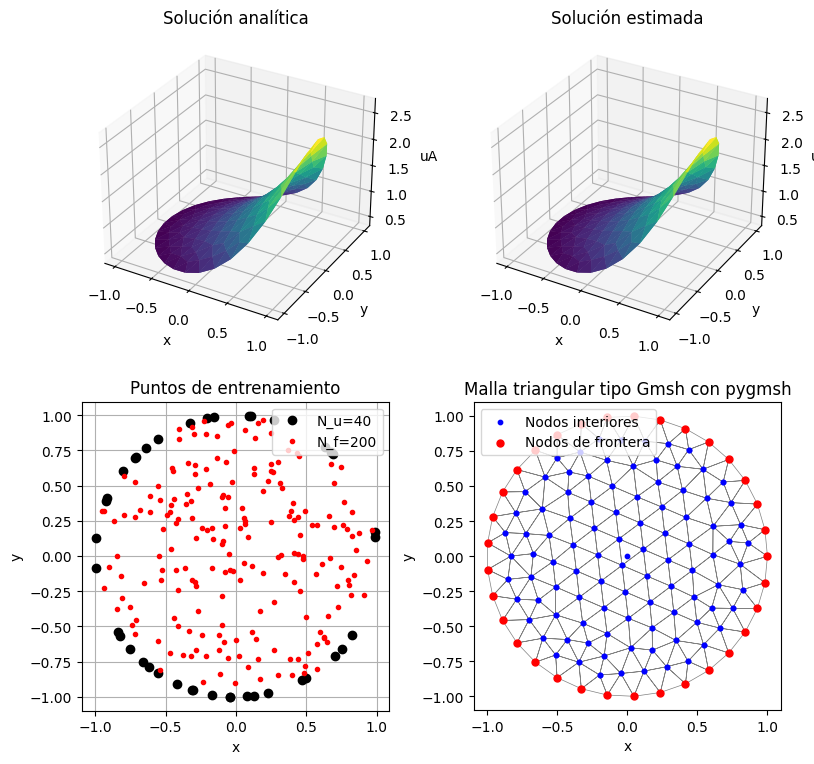

In [18]:
import matplotlib.pyplot as plt                  # Generación de gráficos 2D
from mpl_toolkits.mplot3d import Axes3D          # Gráficos 3D con matplotlib

# .----------------------------------------------.
#  Graficar resultados
# .----------------------------------------------.
#  - Subplot 1: Solución analítica
#  - Subplot 2: Solución predicha
#  - Subplot 3: Distribución de puntos
fig = plt.figure(figsize=(8, 8))

# Subplot 1: Solución analítica
ax1 = fig.add_subplot(221, projection='3d')

ax1.plot_trisurf(xp, yp, up_star, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
# ax1.scatter(X_u_train[:,0], X_u_train[:,1], u_train[:,0], color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('uA')
ax1.set_title('Solución analítica')

# Subplot 2: Solución estimada por la red
ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_trisurf(xp, yp, up_pred, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('uN')
ax2.set_title('Solución estimada')

# Subplot 3: Distribución de puntos de entrenamiento

ax3 = fig.add_subplot(223)
str1 = f'N_u={N_bdy}'
str2 = f'N_f={N_int}'

ax3.plot(x_bdy, y_bdy, 'ok', label=str1) # Boundry
ax3.plot(xu, yu, '.r', label=str2) # Latin HyperCube

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Puntos de entrenamiento')
ax3.set_aspect('equal')
ax3.legend()
ax3.grid(True)

# Subplot 4: Distribución de puntos de prueba

ax4 = fig.add_subplot(224)

ax4.triplot(points[:,0], points[:,1], cells, lw=0.5, color='gray')
ax4.scatter(points[interior_nodes,0], points[interior_nodes,1],
            color='blue', s=10, label='Nodos interiores')
ax4.scatter(points[boundary_nodes,0], points[boundary_nodes,1],
            color='red', s=25, label='Nodos de frontera')
ax4.set_aspect('equal')

ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title("Malla triangular tipo Gmsh con pygmsh")
ax4.legend()

plt.tight_layout()
# plt.savefig('CircResults')
plt.show()

## Absolute error

In [20]:
loss_h, u_loss_h, f_loss_h = model.history()

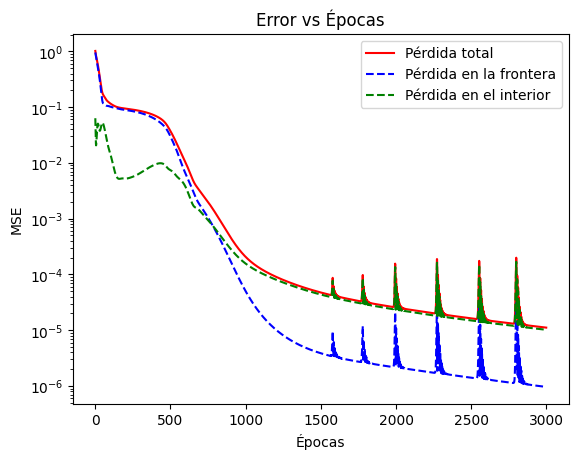

In [21]:
plt.semilogy(range(epochs), loss_h, '-r', label='Pérdida total')
plt.semilogy(range(epochs), u_loss_h, '--b', label='Pérdida en la frontera')
plt.semilogy(range(epochs), f_loss_h, '--g', label='Pérdida en el interior')

plt.title('Error vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('MSE')

plt.legend()

plt.savefig('EpochsCirc')
plt.show()

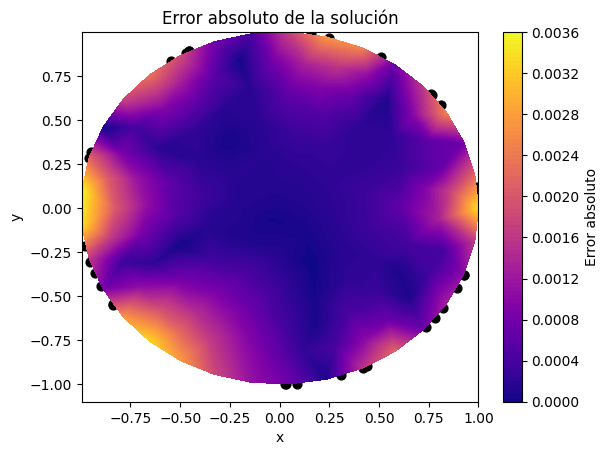

In [62]:
# Subplot 5: Mapa de calor del error
err = np.abs(up_star - up_pred) #Error absoluto

# Puntos de la frontera
plt.scatter(x_bdy, y_bdy,
            color='black', s=40, label='Nodos de frontera')

plt.tricontourf(xp, yp, err, levels=100, cmap='plasma')
plt.colorbar(label='Error absoluto')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Error absoluto de la solución')

plt.savefig('PINN_Abs')
plt.show()

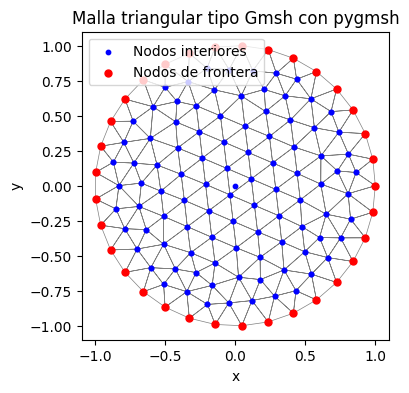

In [23]:
fig = plt.figure(figsize=(4, 4))

ax4 = fig.add_subplot(111)

ax4.triplot(points[:,0], points[:,1], cells, lw=0.5, color='gray')
ax4.scatter(points[interior_nodes,0], points[interior_nodes,1],
            color='blue', s=10, label='Nodos interiores')
ax4.scatter(points[boundary_nodes,0], points[boundary_nodes,1],
            color='red', s=25, label='Nodos de frontera')
ax4.set_aspect('equal')

ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title("Malla triangular tipo Gmsh con pygmsh")
ax4.legend()

# plt.savefig('CircMesh')
plt.show()